In [2]:
using Luna
using Optim
using FFTW
using DelimitedFiles
using Printf
import Luna: Hankel 
using DSP
using Polynomials
using LaTeXStrings


In [3]:
using PyPlot
pygui(true)

true

In [4]:
# useful function for finding the indices for phase blanking manually
function find_closest_index(array, value)
    differences = abs.(array .- value)
    return argmin(differences)
end

find_closest_index (generic function with 1 method)

Plotting how luna processes mirror data


In [5]:
# READING IN MIRROR DATA

file_low_GDD = joinpath("input", "mirrordata_0fs2.txt")
file_high_GDD = joinpath("input", "mirrordata_-30fs2.txt")

data = readdlm(file_low_GDD, skipstart=1)

λR = data[:,1].*1e-9    # read in wavelength [m]
R = data[:,2].*1e-2     # read in reflectivity [fractions]

λGDD = data[:,1].*1e-9  # read in wavelength [m]
GDD = data[:,3].*1e-30  # read in GDD [s]

501-element Vector{Float64}:
 -5.79717419e-28
 -3.61413346e-28
 -2.2142746800000004e-28
 -1.32489848e-28
 -7.7495477e-29
 -4.529729300000001e-29
 -2.8334148000000003e-29
 -2.1224169000000003e-29
 -1.9871232e-29
 -2.0838837000000004e-29
  ⋮
 -2.6209714225e-26
 -1.3096057115e-26
 -9.318107206000002e-27
 -6.717818244000001e-27
 -4.905960325e-27
 -3.621646803000001e-27
 -2.6948734820000003e-27
 -2.014819174e-27
 -2.014819174e-27

In [6]:
# FURTHER PARAMETERS

λ0 = 1030e-9            # central wavelength (used to remove any overall group delay)
fitorder=15              # order of polynomial fit to use in removing overall group delay

λmin = minimum(λR)      # bounds of the wavelength region to apply the transfer function over
λmax = maximum(λR)
windowwidth=20e-9       # wavelength width of the smoothing region outside `(λmin, λmax)` for the window in SI units


# FILTERING FOR A CERTAIN WAVELENGTH REGION?

# λlow = 925e-9 #minimum(λR) # 800e-9
# λhigh = 1165e-9 #maximum(λR) # 1300e-9

# indices = findall(x -> λlow <= x <= λhigh, λR)
# println(indices)

# λR = λR[indices]
# R = R[indices]
# λGDD = λGDD[indices]
# GDD = GDD[indices]


2.0e-8

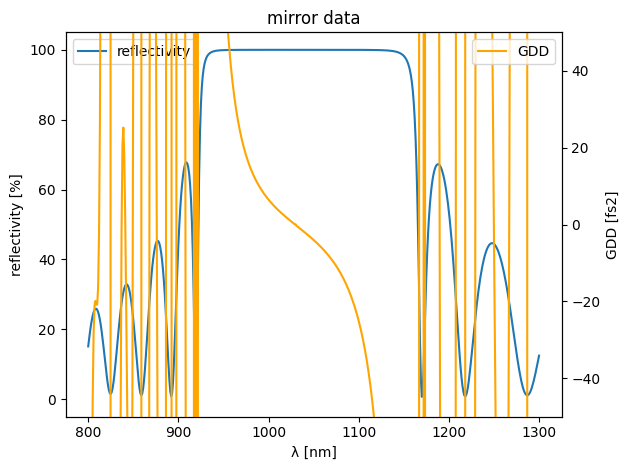

In [7]:
fig, ax1 = plt.subplots()
ax1.set_title("mirror data")
ax1.plot(λR.*1e9, R.*1e2, label="reflectivity")
ax2 = ax1.twinx()
ax2.plot(λGDD.*1e9, GDD.*1e30, label="GDD", color="orange")
ax1.set_ylim(-5, 105)
ax2.set_ylim(-50, 50)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("reflectivity [%]")
ax2.set_ylabel("GDD [fs2]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
display(gcf())

In [8]:
# PROCESSING REFLECTIVITY DATA
r = sqrt.(R)                # Reflectivity to be applied to E (not I)
rspl = Maths.BSpline(λR, r)

Luna.Maths.RealBSpline{Dierckx.Spline1D, Vector{Float64}, Luna.Maths.FastFinder{Vector{Float64}, Float64}}(Spline1D(knots=[8.0e-7,8.02e-7 … 1.298e-6,1.3e-6] (499 elements), k=3, extrapolation="extrapolate", residual=0.0), [0.0, 0.0, 0.0, 0.0], [0.0, 1.2731974746e-313, 4.243991582e-314, 1.0e-323], Luna.Maths.FastFinder{Vector{Float64}, Float64}([8.000000000000001e-7, 8.02e-7, 8.030000000000001e-7, 8.04e-7, 8.05e-7, 8.060000000000001e-7, 8.070000000000001e-7, 8.08e-7, 8.09e-7, 8.100000000000001e-7  …  1.2900000000000001e-6, 1.291e-6, 1.292e-6, 1.2930000000000002e-6, 1.294e-6, 1.295e-6, 1.2960000000000002e-6, 1.297e-6, 1.2980000000000001e-6, 1.3e-6], 8.000000000000001e-7, 1.3e-6, 499, 0, -Inf))

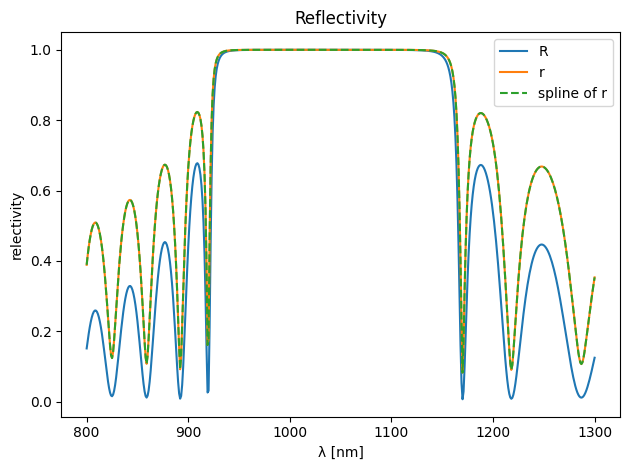

In [9]:
# Plotting reflectivity to be applied to the electric field E
plt.figure()
plt.title("Reflectivity")
plt.plot(λR.*1e9, R, label="R")
plt.plot(λR.*1e9, r, label="r")
plt.plot(λR.*1e9, rspl.(λR), linestyle="--",  label="spline of r")
plt.xlabel("λ [nm]")
plt.ylabel("relectivity")
plt.legend()
plt.tight_layout()
# plt.show()
display(gcf())

In [10]:
# PROCESSING GDD DATA

ω = PhysData.wlfreq.(λGDD)          # converting wavelengths to angular frequencies
ω0 = PhysData.wlfreq(λ0)    # central frequency around which fit is done
ωfs = ω*1e-15                       # converting to fs to work with polynomial fit
ωfs0 = PhysData.wlfreq(λ0)*1e-15    # central frequency around which fit is done

GD = Maths.cumtrapz(GDD, ω)                     # GD data is integrated once
idx = argmin(abs.(ω .- ω0))                     # finding GD at central frequency
GD = GD .- GD[idx]                              # subtracting residual GD at central frequency


ϕ = Maths.cumtrapz(Maths.cumtrapz(GDD, ω), ω)   # GDD data is integrated twice to get whole phase
                                                # GDD is defined as the second derivative of the phase
p = Polynomials.fit(ωfs .- ωfs0, ϕ, fitorder)   # phase from GDD data is fitted
ϕ_fit = p.(ωfs .- ωfs0)                         

501-element Vector{Float64}:
   7.2160667495721
   1.236104363345947
  -2.284580170728905
  -4.019961643648831
  -4.505483390498838
  -4.160806234416042
  -3.3094454141252365
  -2.1956610695995855
  -0.9989301203664335
   0.15370691767449576
   ⋮
 895.8736782630215
 901.3950467208496
 906.5765165020497
 911.3639637293174
 915.6985202054154
 919.5163151103692
 922.7482077889734
 925.319511450885
 927.1497076050914

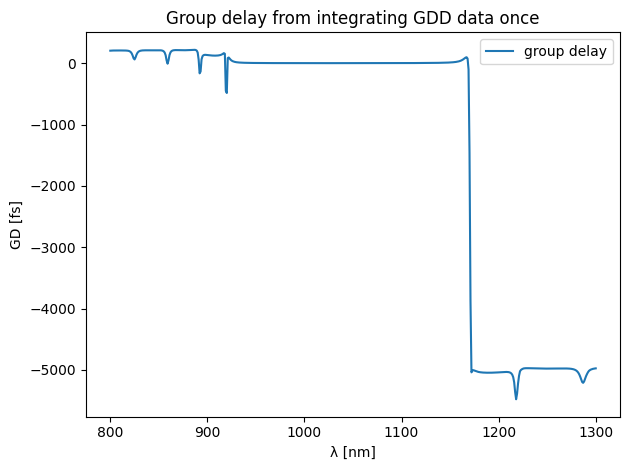

In [11]:
# Plotting the phase from given GDD values (by integrating the GDD twice)
plt.figure()
plt.title("Group delay from integrating GDD data once")
plt.plot(λGDD.*1e9, GD.*1e15, label="group delay")
plt.xlabel("λ [nm]")
plt.ylabel("GD [fs]")
plt.legend()
plt.tight_layout()

# plt.show()
display(gcf())

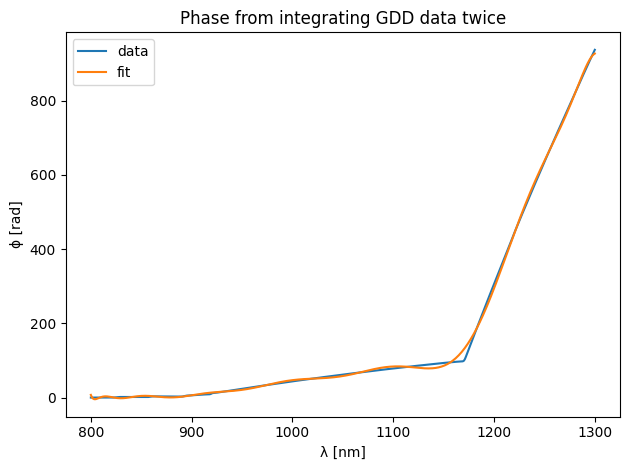

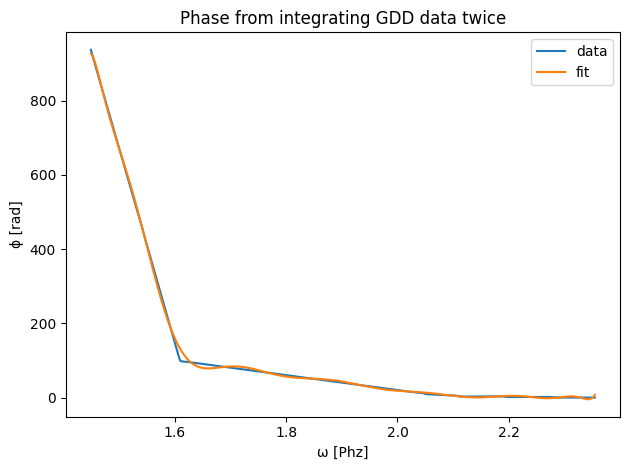

In [12]:
# Plotting the phase from given GDD values (by integrating the GDD twice)
plt.figure()
plt.title("Phase from integrating GDD data twice")
plt.plot(λGDD.*1e9, ϕ, label="data")
plt.plot(λGDD.*1e9, ϕ_fit, label="fit")
plt.xlabel("λ [nm]")
plt.ylabel("ϕ [rad]")
plt.legend()
plt.tight_layout()
display(gcf())

# Plotting the phase from given GDD values (by integrating the GDD twice)
plt.figure()
plt.title("Phase from integrating GDD data twice")
plt.plot(ωfs, ϕ, label="data")
plt.plot(ωfs, ϕ_fit, label="fit")
plt.xlabel("ω [Phz]")
plt.ylabel("ϕ [rad]")
plt.legend()
plt.tight_layout()
display(gcf())

# plt.show()


In [13]:
# SUBTRACT LINEAR TERMS FROM FITTED PHASE

println(p)
println("p[0] = ",p[0])
println("p[1] = ",p[1])
println("p[2] = ",p[2])

p[2:end] = 0 # polynomials use 0-based indexing - only use constant and linear term
println(p)

ϕ_nonlin = ϕ .- p.(ωfs .- ωfs0) # subtract linear part from phase
ϕspl = Maths.BSpline(λGDD, ϕ)

52.3241 - 87.4191*x + 1386.13*x^2 - 29689.6*x^3 - 84940.2*x^4 + 2.02082e6*x^5 - 2.90227e5*x^6 - 5.20801e7*x^7 + 8.08718e7*x^8 + 5.49084e8*x^9 - 1.33298e9*x^10 - 2.2658e9*x^11 + 8.36415e9*x^12 + 2.64032e8*x^13 - 1.86715e10*x^14 + 1.44845e10*x^15
p[0] = 52.324115004585565
p[1] = -87.41914188611771
p[2] = 1386.1306636263157
52.3241 - 87.4191*x


Luna.Maths.RealBSpline{Dierckx.Spline1D, Vector{Float64}, Luna.Maths.FastFinder{Vector{Float64}, Float64}}(Spline1D(knots=[8.0e-7,8.02e-7 … 1.298e-6,1.3e-6] (499 elements), k=3, extrapolation="extrapolate", residual=0.0), [0.0, 0.0, 0.0, 0.0], [6.79469264908e-312, 6.794692649315e-312, 6.79469264955e-312, 6.79469264979e-312], Luna.Maths.FastFinder{Vector{Float64}, Float64}([8.000000000000001e-7, 8.02e-7, 8.030000000000001e-7, 8.04e-7, 8.05e-7, 8.060000000000001e-7, 8.070000000000001e-7, 8.08e-7, 8.09e-7, 8.100000000000001e-7  …  1.2900000000000001e-6, 1.291e-6, 1.292e-6, 1.2930000000000002e-6, 1.294e-6, 1.295e-6, 1.2960000000000002e-6, 1.297e-6, 1.2980000000000001e-6, 1.3e-6], 8.000000000000001e-7, 1.3e-6, 499, 0, -Inf))

In [14]:
println(PhysData.wlfreq.(1030e-9))

1.8287879294260708e15


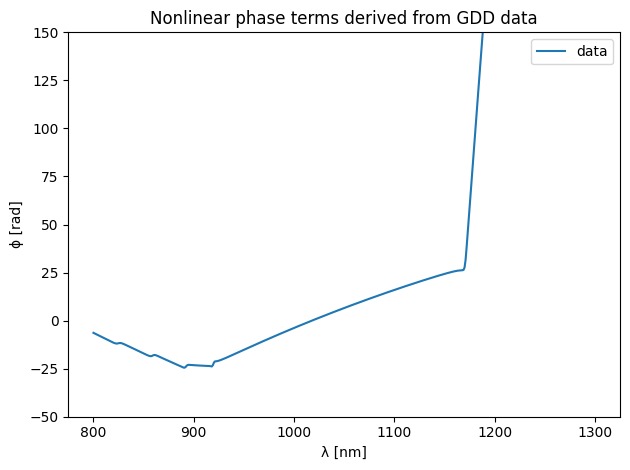

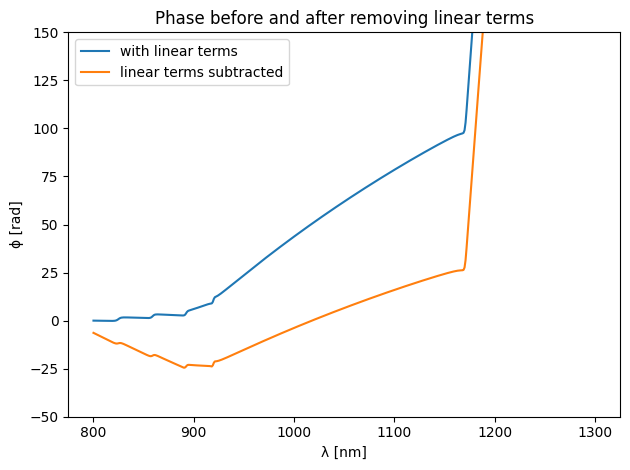

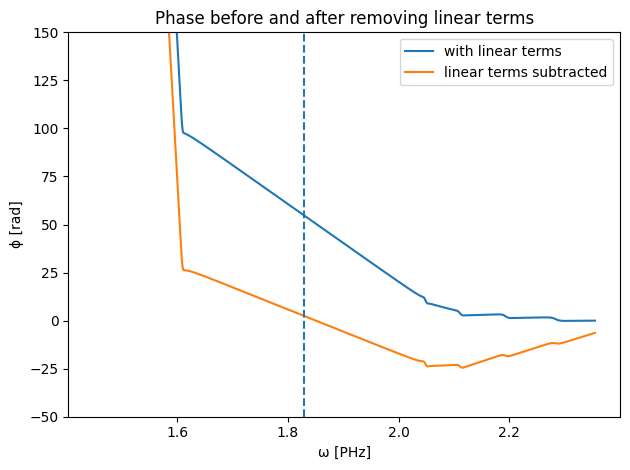

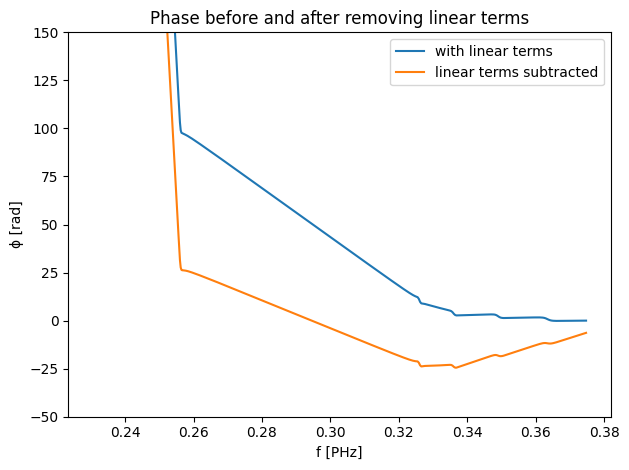

In [15]:
# Plotting the phase from given GDD values (by integrating the GDD twice)

plt.figure()
plt.title("Nonlinear phase terms derived from GDD data")
plt.plot(λGDD.*1e9, ϕ_nonlin, label="data")
#plt.plot(λGDD.*1e9, ϕspl, linestyle="--", label="spline")
#plt.plot(λGDD.*1e9, ϕ_fit, label="fit")
plt.xlabel("λ [nm]")
plt.ylabel("ϕ [rad]")
plt.ylim(-50,150)
plt.legend()
plt.tight_layout()
display(gcf())

plt.figure()
plt.title("Phase before and after removing linear terms")
plt.plot(λGDD.*1e9, ϕ, label="with linear terms")
plt.plot(λGDD.*1e9, ϕ_nonlin, label="linear terms subtracted")
plt.xlabel("λ [nm]")
plt.ylabel("ϕ [rad]")
plt.ylim(-50,150)
plt.legend()
plt.tight_layout()
display(gcf())

plt.figure()
plt.title("Phase before and after removing linear terms")
plt.plot(ωfs, ϕ, label="with linear terms")
plt.plot(ωfs, ϕ_nonlin, label="linear terms subtracted")
plt.axvline(1.8287879294260708, linestyle="dashed")
plt.xlabel("ω [PHz]")
plt.ylabel("ϕ [rad]")
plt.ylim(-50,150)
plt.legend()
plt.tight_layout()
display(gcf())

plt.figure()
plt.title("Phase before and after removing linear terms")
plt.plot(ωfs/(2*pi), ϕ, label="with linear terms")
plt.plot(ωfs/(2*pi), ϕ_nonlin, label="linear terms subtracted")
plt.xlabel("f [PHz]")
plt.ylabel("ϕ [rad]")
plt.ylim(-50,150)
plt.legend()
plt.tight_layout()
display(gcf())

# plt.show()

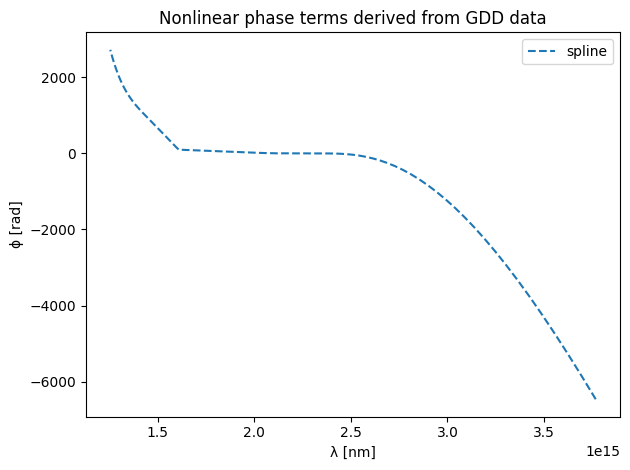

In [16]:
λ = collect(500:10:1500).*1e-9
ω = PhysData.wlfreq.(λ)

plt.figure()
plt.title("Nonlinear phase terms derived from GDD data")
plt.plot(ω, ϕspl.(λ), linestyle="--", label="spline")
plt.xlabel("λ [nm]")
plt.ylabel("ϕ [rad]")
plt.legend()
plt.tight_layout()

# plt.show()
display(gcf())

In [17]:
λ -> rspl(λ) * exp(-1im*ϕspl(λ)) * Maths.planck_taper(λ, λmin-windowwidth, λmin, λmax, λmax+windowwidth)

#11 (generic function with 1 method)

Creating own function to apply reflectivity

In [18]:
run = "run_2024_12_16__15_17_58_direct_-30fs2_GDD"
file_MPC_spectrum_sim = joinpath("output_sorted", "direct GDD", run , "output_spectrum.txt")

data = readdlm(file_MPC_spectrum_sim, '\t', Float64, '\n')

λ_sim = data[:, 1].*1e-9
I_sim = data[:, 2]
I_sim ./= maximum(I_sim)

1024-element Vector{Float64}:
 2.046688564588101e-21
 2.167504669710736e-21
 2.3590276821696847e-21
 2.6074499983627354e-21
 2.8952457274658733e-21
 3.2027644409004377e-21
 3.510003370561535e-21
 3.798388379540761e-21
 4.052386658472661e-21
 4.2608079352128505e-21
 ⋮
 3.3492754007971526e-22
 2.650108828822963e-22
 2.0130385274291529e-22
 1.4505998668002392e-22
 9.739825795465094e-23
 5.92780819785854e-23
 3.1475075416305647e-23
 1.4560091341448566e-23
 8.882580199551299e-24

In [19]:
# MIRROR 1
path_m1 = joinpath("input", "mirrordata_0fs2.txt")
data = readdlm(path_m1, skipstart=1)

λ_m1 = data[:,1].*1e-9     # read in wavelengths [m]
R_m1 = data[:,2].*1e-2     # read in reflectivity [fractions]
GDD_m1 = data[:,3].*1e-30  # read in GDD [s^2]

# for planck taper function
windowwidth1 = 50e-9
λ_min0 = minimum(λ_m1)
λ_min1 = minimum(λ_m1)+windowwidth1
λ_max1 = maximum(λ_m1)-windowwidth1
λ_max0 = maximum(λ_m1)

# add additional group delay if necessary
delay1 = 200e-15

2.0e-13

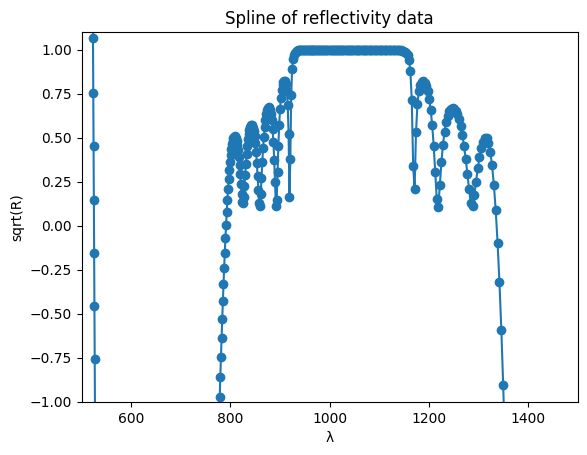

In [20]:
r = sqrt.(R_m1)
rspl = Maths.BSpline(λ_m1, r)

plt.figure()
plt.title("Spline of reflectivity data")
plt.plot(λ_sim.*1e9, rspl.(λ_sim), label="rspl", marker="o")
plt.xlim(500, 1500)
plt.ylim(-1, 1.1)
plt.xlabel("λ")
plt.ylabel("sqrt(R)")
# plt.show()
display(gcf())


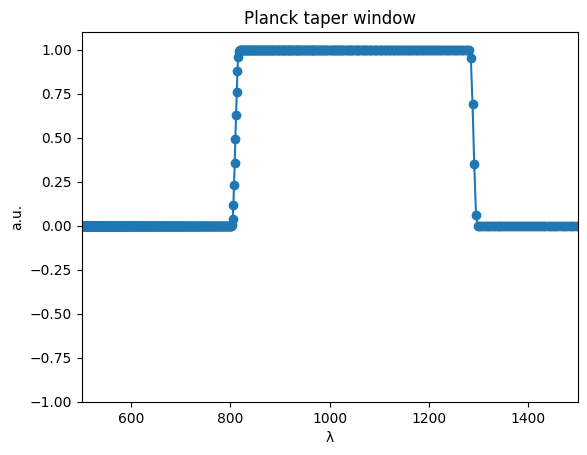

In [21]:
pt = Maths.planck_taper(λ_sim.*1e9, 800, 820, 1280, 1300)

plt.figure()
plt.title("Planck taper window")
plt.plot(λ_sim.*1e9, pt, label="pt", marker="o")
plt.xlim(500, 1500)
plt.ylim(-1, 1.1)
plt.xlabel("λ")
plt.ylabel("a.u.")
# plt.show()
display(gcf())

[1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 1.0e-15, 

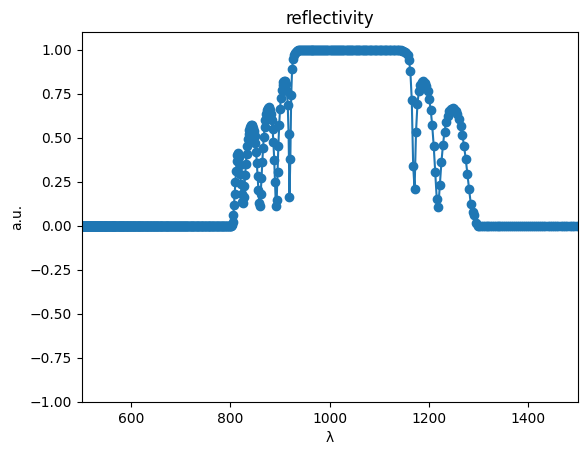

In [22]:
r = rspl.(λ_sim) .* pt

mask = (λ_sim .<= minimum(λ_m1)) .| (λ_sim .>= maximum(λ_m1))
r[mask] .= 1e-15

# # Create a mask for wavelengths within the specified window
# within_window = (λ_sim .>= minimum(λ_m1)) .& (λ_sim .<= maximum(λ_m1))

# # Set reflectivity to 1 outside the wavelength window
# # r .!= 1
# r[.!within_window] .= 1e-15

# Print the updated reflectivity array
println(r)


plt.figure()
plt.title("reflectivity")
plt.plot(λ_sim.*1e9, r, label="pt", marker="o")
plt.xlim(500, 1500)
plt.ylim(-1, 1.1)
plt.xlabel("λ")
plt.ylabel("a.u.")
# plt.show()
display(gcf())

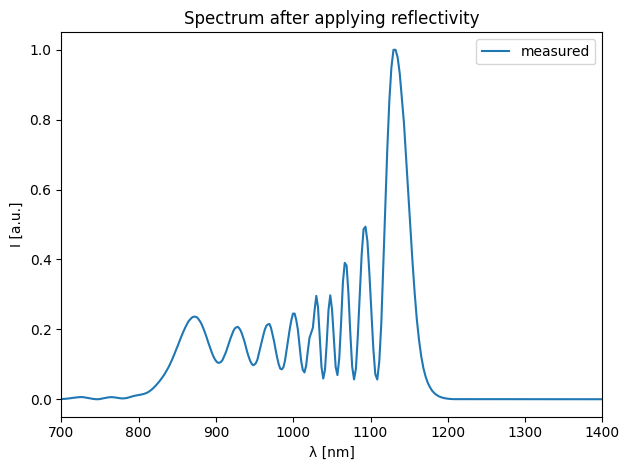

In [23]:
# Plotting measured MPC spectrum
plt.figure()
plt.title("Spectrum after applying reflectivity")
plt.plot(λ_sim.*1e9, I_sim, label="measured")
#plt.plot(λ_sim.*1e9, I_sim, label="simulated")
plt.xlabel("λ [nm]")
plt.ylabel("I [a.u.]")
plt.xlim(700, 1400)
plt.legend()
plt.tight_layout()
# plt.show()
display(gcf())

In [24]:
pt = planck_taper(λ_sim, 800, 820, 1280, 1300)

plt.figure()
plt.plot(λ_sim, pt)
plt.xlim(600, 1500)
# plt.show()
display(gcf())

UndefVarError: UndefVarError: `planck_taper` not defined

In [25]:
mask = (λ_sim .<= 800) .| (λ_sim .>= 1300)
pt[mask] .= 1e-30

1024-element view(::Vector{Float64}, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024]) with eltype Float64:
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 ⋮
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30
 1.0e-30

# Applying mirror function
See how the spectrum/pulse gets affected when applying the porp_mirror function without any propagation.

*Defining the pulse with all necessary parameters the same way its done in the simulation script*\
*Get Ẽωk in the end*

In [26]:
use_FROG_spectrum = false
    
    # pulse parameters
    λ0 = 1030e-9        # central wavelength [m]
    τ = 150e-15         # pulse duration [s]; ignored if FROG spectrum is used
    E_pulse = 250e-6    # pulse energy [J]
    #w0 = 150e-6         # beam waist at focus [m]      # instead calculated later
    #M2 = 1.16           # beam quality                 # not yet implemented; how would you do that?

    # MPC parameters
    L = 380.1934e-3          # MPC cell length [m]
    R = 200e-3          # radius of curvature [m]
    propz = -L/2         # propagation distance from the waist [m] (distance between mirror position and focal position)
    z_vals = L .* [0, 1/2, 1]     # points along the cell at which to investigate beam evolution [m]

    Nrt = 15           # number of round trips
    Npass = 30 #2*Nrt       # number of passes

    pres = 1.5 #10e-8 #1.5               # gas pressure [bar]
    gas = :Kr           # gas type

    ion = true         # if true: enable ionisation response, if false: disable ionisation 
    ion_model="PPT"    # set to "ADK" or "PPT" (has no effect if ion==false); "ADK" is less accurate at low intensities but faster; "PPT" may crash at very high intensities

    
    # simulation grid parameters
    λlims = (700e-9, 1400e-9) #(700e-9, 1400e-9) #(600e-9, 1500e-9) # wavelength range of interest [m]
    trange = 10*τ #300.0e-15 #0.05e-12    # total extent of time window required [s], default was 50fs (NOTE: if this is too short, the range is extended automatically; this value was taken from an older version of the code; no justification!)
    Nz = 201                            # number of points along z at which the spectrum is saved
    

    # calculate theoretical beam size in the MPC (as in https://doi.org/10.1364/OPTICA.449225 eq. 3 and 4)
        C = L/R 

        # beam waist in the focus
        w02 = R*λ0 * sqrt(C*(2-C)) /2pi
        w0 = sqrt(w02)                                                # ! this value is used to define the gaussian beam in the beginning of the simulation
        @printf("Input focal spot radius w0 = %.2f µm\n", w0*1e6)

        # beam waist on the mirror
        wm2 = R*λ0 * sqrt(C/(2-C)) /pi
        wm = sqrt(wm2) 
        @printf("Calculated spot radius at the mirror location wm = %.2f µm\n", wm*1e6)


    # initialize arrays to track beam size and intensity at L/2 and L (in the center of the cell and at the mirror position)
        w_0 = []
        w_m = []

        I_0 = []
        I_m = []          


    # Hankel transformation
    R_hankel = 3.0*wm           # aperture radius for Hankel transform (assume field ≈0 for r>R ) [m]  
    N_hankel = 512 #256 #512 #1024             # sample size for Hankel tansform grid 

# ----------------- SET SIMULATION GRID ----------------------------

    q = Hankel.QDHT(R_hankel, N_hankel, dim=2)                  # set up discrete Hankel transform matrix 
    grid = Grid.RealGrid(L, λ0, λlims, trange)               # set up time & space grid for gradient approximation 
                       
    energyfun, energyfun_ω = Fields.energyfuncs(grid, q)    # "energyfun" gives total energy in a field E(t); energyfun_ω is needed in case field is defined via FROG spectrum  


# ----------------- SET NONLINEAR EFFECTS ----------------------------

    ionpot = PhysData.ionisation_potential(gas)                 # set gas ionisation potential   

    if ion_model=="ADK"
        ionrate = Ionisation.ionrate_fun!_ADK(gas)                  # set gas ionisation rate (ADK)
    elseif ion_model=="PPT"
        ionrate = Ionisation.ionrate_fun!_PPTcached(gas, λ0)        # set gas ionisation rate (PPT)
    end    

    n_gas = PhysData.ref_index_fun(gas, pres)                       # refractive index of the gas for given pressure (no pressure profile, pressure is constant)

    linop = LinearOps.make_const_linop(grid, q, n_gas)              # generate linear operator for pulse-propagation equation
    normfun = NonlinearRHS.const_norm_radial(grid, q, n_gas)        # generate normalisation function for radial symmetry


    # * * * SET KERR EFFECT AND/OR PLASMA FORMATION 
    if ion == true                             # nonlinear response function with ionisation and Kerr effect
        responses = (Nonlinear.Kerr_field(PhysData.γ3_gas(gas)),     
                Nonlinear.PlasmaCumtrapz(grid.to, grid.to, ionrate, ionpot),)  
    elseif ion == false                        # nonlinear response function without ionisation, just Kerr effect
        responses = (Nonlinear.Kerr_field(PhysData.γ3_gas(gas)),)    
    end 

# ---------------- SET GAS DENSITY ----------------
    densityfun = let dens0=PhysData.density(gas, pres)      # pressure is constant in MPC
        z -> dens0 
    end

# ---------------- SET UP SIMULATION -------------------
    if use_FROG_spectrum==true
        inputs = () # leave input field empty as we will be defined later by the FROG spectrum

    else
        # input field
        # to get a converging beam, we define a Gaussian spot with size w0
        # and then *back-propagate* by L/2 i.e. by half of our propagation window
        # this means the nominal focus is halfway through our propagation in this example
        inputs = Fields.GaussGaussField(λ0=λ0, τfwhm=τ, energy=E_pulse, w0=w0, propz=propz)
    end

    Ẽωk, transform, FT = Luna.setup(grid, q, densityfun, normfun, responses, inputs)  # set up propagation; Eωk is overwritten when FROG spectrum is used

Input focal spot radius w0 = 119.27 µm
Calculated spot radius at the mirror location wm = 535.99 µm


┌ Info: Freq limits 0.21 - 0.43 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 3854.47, samples: 4096, δt = 389.16 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 1500.0 fs, actual time window: 1594.0 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 2048 / 4096, ωmax 4.04e+15 / 8.07e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78
┌ Info: Found cached PPT rate for 13.99 eV, 1030.0 nm
└ @ Luna.Ionisation C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Ionisation.jl:145
┌ Info: Found FFTW wisdom at C:\Users\muelderk\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
└ @ Luna.Utils C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Utils.jl:90
┌ Info: FFTW wisdom saved to C:\Users\muelderk\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcac

(ComplexF64[3.5669278556101372e-12 + 0.0im 3.447852773990851e-12 + 0.0im … -3.287167622226445e-17 + 0.0im -1.7932237692048662e-17 + 0.0im; 3.003377449024466e-12 - 1.6950516414001785e-12im -9.952409903402e-13 - 3.1817654980427096e-12im … 2.5296189916735918e-17 - 2.999555312138321e-17im 1.2956349922803994e-17 - 1.5860788826291607e-17im; … ; 5.768539781463786e-13 - 7.271679252902717e-15im 5.553738475254657e-13 - 4.460690080939334e-14im … -3.054292663417867e-17 - 3.8926031586043207e-17im 2.14750303503107e-18 + 2.6195679879063072e-17im; -6.408942385630443e-13 + 1.0120545848192942e-14im -6.169897444314946e-13 + 5.145011454797541e-14im … -1.377606450216583e-16 - 2.2690209555651846e-16im -1.3277021532765874e-17 + 1.336653118116837e-16im], TransRadial
  grid type: Luna.Grid.RealGrid
  time grid size: 2048 / 4096
  radial points: 512
  aperture: 0.0016079723967822581
  responses: Luna.Nonlinear.var"#Kerr#1"{Float64}
    Luna.Nonlinear.PlasmaCumtrapz{Luna.Ionisation.var"#ionrate!#20"{Float64, Flo

*transform from reciprocal to real space*

In [27]:
println(size(Ẽωk))

# transform to Ẽ(ω, r)
Ẽωr = q \ Ẽωk # inverse QDHT: Ẽωk is Ẽ(ω, k) so Ẽωr is Ẽ(ω, r)

println(size(Ẽωr))

(1025, 512)
(1025, 512)


*Defining mirror functions*

In [28]:
function reflecting_mirror1!(Eωr)

    print("Applying reflectivity and GDD data of mirror 1...")
    Fields.prop_mirror!(Eωr, grid.ω, 1, λ_m1, R_m1, λ_m1, GDD_m1, λ0, λ_min1, λ_max1, windowwidth=windowwidth1) 
    
    if delay1 !== nothing
        # adding additional linear phase
        ω0 = PhysData.wlfreq(λ0)
        ϕ_delay = delay1 .* (grid.ω .- ω0)
        Eωr .*= exp.(-1im*ϕ_delay)
    end

    println("done.")
end

function reflecting_mirror2!(Eωr)

    print("Applying reflectivity and GDD data of mirror 2...")
    Fields.prop_mirror!(Eωr, grid.ω, 1, λ_m2, R_m2, λ_m2, GDD_m2, λ0, λ_min2, λ_max2, windowwidth=windowwidth2) 

    if delay2 !== nothing
        # adding additional linear phase
        ω0 = PhysData.wlfreq(λ0)
        ϕ_delay = delay2 .* (grid.ω .- ω0)
        Eωr .*= exp.(-1im*ϕ_delay)
    end

    println("done.")
end

reflecting_mirror2! (generic function with 1 method)

*Defining mirror data*

In [29]:
# mirror data files
path_m1 = joinpath("input", "mirrordata_0fs2.txt") # "mirrordata_0fs2.txt"; "mirror_R_100_GDD_0fs2.txt"; "mirror_R_data_GDD_0fs2.txt"
path_m2 = joinpath("input", "mirrordata_-30fs2.txt") # "mirrordata_-30fs2.txt"; "mirror_R_100_GDD_-30fs2.txt"; "mirror_R_data_GDD_-30fs2.txt"


# MIRROR 1
data = readdlm(path_m1, skipstart=1)

λ_m1 = data[:,1].*1e-9     # read in wavelengths [m]
R_m1 = data[:,2].*1e-2     # read in reflectivity [fractions]
GDD_m1 = data[:,3].*1e-30  # read in GDD [s^2]

# for planck taper function
windowwidth1 = 20e-9
λ_min1 = minimum(λ_m1)+windowwidth1
λ_max1 = maximum(λ_m1)-windowwidth1

# add additional group delay if necessary
delay1 = nothing #200e-15


# MIRROR 2
data = readdlm(path_m2, skipstart=1)

λ_m2 = data[:,1].*1e-9     # read in wavelengths [m]
R_m2 = data[:,2].*1e-2     # read in reflectivity [fractions]
GDD_m2 = data[:,3].*1e-30  # read in GDD [s^2]

# for planck taper function
windowwidth2 = 20e-9
λ_min2 = minimum(λ_m2)+windowwidth2
λ_max2 = maximum(λ_m2)-windowwidth2

# add additional group delay if necessary
delay2 = nothing

*Applying mirror reflections to the pulse*

In [41]:
Ẽωr_refl = copy(Ẽωr)
num_refl = 7

for i in 1:num_refl
    if isodd(i)
        reflecting_mirror1!(Ẽωr_refl) 
    else
        reflecting_mirror2!(Ẽωr_refl) 
    end
end


Applying reflectivity and GDD data of mirror 1...done.
Applying reflectivity and GDD data of mirror 2...done.
Applying reflectivity and GDD data of mirror 1...done.
Applying reflectivity and GDD data of mirror 2...done.
Applying reflectivity and GDD data of mirror 1...done.
Applying reflectivity and GDD data of mirror 2...done.
Applying reflectivity and GDD data of mirror 1...done.


In [42]:
Ẽω_refl = zeros(ComplexF64, (size(Ẽωr_refl, 1)))      # set up new array for Ẽω = Ẽ(ω, z); COMPLEX electric field amplitude in FREQUENCY domain INTEGRATED along r (from 0 to infinity to my knowledge)
        
for i = 1:size(Ẽωr_refl, 1)
    Ẽω_refl[i] = Hankel.integrateR(Ẽωr_refl[i,:], q)             # integrate along r (technically: k)
end


Ẽω = zeros(ComplexF64, (size(Ẽωr, 1)))      # set up new array for Ẽω = Ẽ(ω, z); COMPLEX electric field amplitude in FREQUENCY domain INTEGRATED along r (from 0 to infinity to my knowledge)
        
for i = 1:size(Ẽωr_refl, 1)
    Ẽω[i] = Hankel.integrateR(Ẽωr[i,:], q)             # integrate along r (technically: k)
end

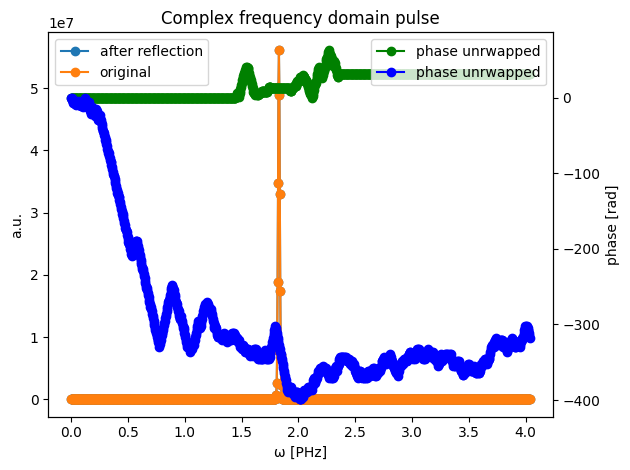

In [43]:
# Plot complex spectral field

fig, ax1 = plt.subplots()
ax1.set_title("Complex frequency domain pulse")
ax1.plot(grid.ω.*1e-15, abs2.(Ẽω_refl), label="after reflection", marker="o")
ax1.plot(grid.ω.*1e-15, abs2.(Ẽω), label="original", marker="o")
#ax1.plot(grid.ω.*1e-15, real.(Ẽω_refl), label="real", marker="o")
#ax1.plot(grid.ω.*1e-15, imag.(Ẽω_refl), label="imaginary", marker="o")
ax2 = ax1.twinx()
#ax2.plot(grid.ω.*1e-15.*1e-15, angle.(Ẽω_refl), label="phase", color="orange")
ax2.plot(grid.ω.*1e-15, unwrap(angle.(Ẽω_refl), dims=1), label="phase unrwapped", color="green", marker="o")
ax2.plot(grid.ω.*1e-15, unwrap(angle.(Ẽω), dims=1), label="phase unrwapped", color="blue", marker="o")

#ax1.set_xlim(-500, 500)
ax1.set_xlabel("ω [PHz]")
ax1.set_ylabel("a.u.")
ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
#plt.show()
display(gcf())

In [44]:
# Nω = length(ω)
# Nt = 2*(Nω-1)

Et = FFTW.irfft(Ẽω, length(grid.t))          # Et = E(t, z) ; REAL electic field amplitude in TIME domain INTEGRATED along r       #total time-domain real field amplitude across all radii
Ẽt = Maths.hilbert(Et)

It = abs2.(Ẽt)                   #  It = I(t, z); intensity in TIME domain, INTEGRATED along r [arbitrary units]

Et_refl = FFTW.irfft(Ẽω_refl, length(grid.t))          # Et = E(t, z) ; REAL electic field amplitude in TIME domain INTEGRATED along r       #total time-domain real field amplitude across all radii
Ẽt_refl = Maths.hilbert(Et_refl)

It_refl = abs2.(Ẽt_refl)                   #  It = I(t, z); intensity in TIME domain, INTEGRATED along r [arbitrary units]

2048-element Vector{Float64}:
 2658.1972814016176
 2661.0688297363395
 2663.545864023604
 2665.6272752218592
 2667.312130559585
 2668.5996742319317
 2669.4893279657836
 2669.9806914525752
 2670.07354264849
 2669.767837941672
    ⋮
 2614.869173515879
 2621.212868426818
 2627.1797838899583
 2632.7672770313147
 2637.972869219092
 2642.7942478960067
 2647.22926829134
 2651.275955010934
 2654.9325035034844

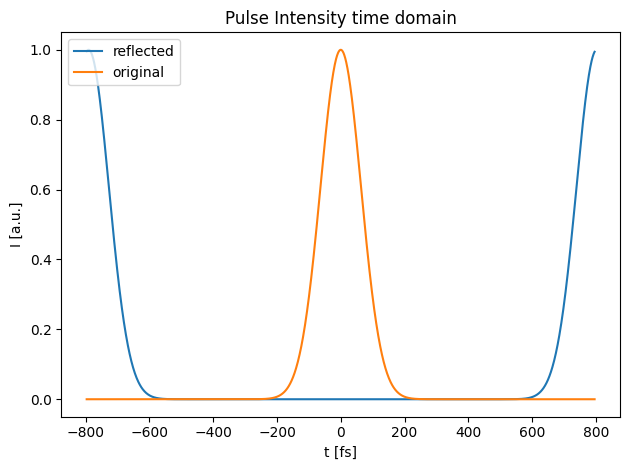

sys:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


In [48]:
# Plot complex time domain field

fig, ax1 = plt.subplots()
ax1.set_title("Pulse Intensity time domain")
ax1.plot(grid.t.*1e15, Maths.normbymax(It_refl), label="reflected")#, marker="o")
ax1.plot(grid.t.*1e15, Maths.normbymax(It), label="original")#, marker="o")
ax1.set_xlabel("t [fs]")
ax1.set_ylabel("I [a.u.]")
ax1.legend(loc="upper left")
plt.tight_layout()
#plt.show()
display(gcf())